# Microsoft Vidur Power Model Explanation & Experiment Results

### Power & Energy/Carbon Model Setup

Since the Vidur simulation is missing energy calculations, and I hope to contribute to the simulation, I integrated a simple power model, which I utilized to estimate energy consumption and carbon emissions. I took inspiration from LLMCarbon's GitHub repository, which is the only existing tool designed to estimate carbon emissions of LLMs end-to-end. Although this implementation on the statistics extraction script that I wrote to integrate into the Vidur simulator has lots of limitations, it is aimed at serving as a blueprint, and I will be removing the limitations one by one as I go through my capstone journey.

### 1. **Power Model (GPU Power Consumption)**
The power consumption for a single GPU is calculated based on the GPU type and its utilization (measured as MFU here). The total power for the entire system can be computed by:

$$
P_{\text{total}} = P_{\text{GPU}} \times \text{MFU} \times \text{GPU}_{\text{hours}}
$$

where:
- P_GPU is the power draw of a single GPU (e.g., A100 = 300W).
- MFU is the GPU utilization (model FLOPs utilization).
- GPU_hours is the total GPU hours for the experiment.

#### Critical Assumptions with this Model:
- From how GPU hours is calculated in the code (df["gpu_hrs"] = df["runtime"] * df["num_gpus"] / 3600), the model assumes that runtime remains constant, regardless of the number of GPUs involved. It seems like the runtime calculation also doesn't reduce runtime for a specific inference task in the presence of multiple GPUs (however, it includes communication overhead for tensor and pipeline parallelism).
- All GPUs have uniform utilization (MFU), while in reality, load balancing might not be perfect across GPUs.
- Power scales linearly with utilization. However, idle or partial utilization may still incur significant power consumption.
- All GPUs consume a constant amount of power. In reality, thermal effects and DVFS can alter power consumption during an experiment.

### 2. **Energy Consumption Model**
The total energy consumption is the product of power consumption and time. For multiple GPUs, the energy consumption can be calculated as:

$$
E_{\text{GPU}} = P_{\text{GPU}} \times \text{GPU}_{\text{hours}} \times \text{MFU}
$$

Then, to account for the inefficiencies in data center operations, the total energy consumption is adjusted by the **PUE** (Power Usage Effectiveness), which leads to:

$$
E_{\text{total}} = E_{\text{GPU}} \times \text{PUE}
$$

where:
- E_GPU is the energy consumed by the GPUs.
- PUE is the Power Usage Effectiveness, which accounts for data center overhead (typically between 1.2 and 1.5, and assumed to be 1.3 in my experiments).

### 3. **Carbon Emissions Model**
The carbon emissions are calculated based on the total energy consumed and the **carbon intensity** (grams of CO2 emitted per kilowatt-hour). This can be modeled as:

$$
C_{\text{emissions}} = E_{\text{total}} \times CI
$$

where:
- C_emissions is the total carbon emissions (gCO2eq).
- E_total is the total energy consumed (kWh).
- CI is the carbon intensity of the energy grid (gCO2eq per kWh).

In [ ]:
# Libraries to install for visualizations

import json
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Experiment 1: Scaling Tensor Parallelism with Number of Replicas
- **Varied input parameters:**
  - Number of replicas: [1, 4, 8, 16]
  - Tensor parallel size: [1, 2, 4]

- **Rest of the input parameters:**
  - Device: A100 GPU
  - Model: `meta-llama/Llama-2-7b-hf`
  - Pipeline stages: 2
  - Max tokens: 4096
  - Request generator: synthetic (with a fixed number of requests, 8000)

- **Method:**
  - The experiment simulates multiple configurations by varying the number of **replicas** and **tensor parallel** sizes. For each configuration, it captures key metrics visualized below.

- **Reasoning and expected outcomes:**
  - **Why vary these parameters?** Replicas and tensor parallelism directly impact computational distribution and workload scaling. By increasing both, the computation load is distributed more efficiently across GPUs, potentially lowering energy consumption and increasing throughput.
  - **Expected outcomes:** As the number of replicas and tensor parallel size increase, energy consumption is expected to reduce proportionally, while carbon emissions should also decrease. However, beyond certain thresholds, diminishing returns in energy efficiency might be observed.

In [ ]:
# Load the experiment1_results.json file
file_path = '/experiment1_results.json'

with open(file_path, 'r') as f:
    experiment1_results = json.load(f)

# Extract the values for x (replicas), y (tensor parallel size), and z (total energy consumption)
replicas = [result['replicas'] for result in experiment1_results]
tensor_parallel_size = [result['tensor_parallel_size'] for result in experiment1_results]
total_energy_kwh = [result['total_energy_kwh'] for result in experiment1_results]

# Create a 3D scatter plot using Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=replicas,
    y=tensor_parallel_size,
    z=total_energy_kwh,
    mode='markers',
    marker=dict(
        size=5,
        color=total_energy_kwh,  # Color by energy consumption
        colorscale='Viridis',
        opacity=0.8
    )
)])

# Add labels and titles
fig.update_layout(
    title="Impact of Replicas and Tensor Parallelism on Energy Consumption",
    scene=dict(
        xaxis_title='Replicas',
        yaxis_title='Tensor Parallel Size',
        zaxis_title='Energy Consumption (kWh)'
    )
)

# Show the plot
fig.show()

In [ ]:
# Convert experiment1_results to a DataFrame for easier manipulation
df = pd.DataFrame(experiment1_results)

# Create a line plot of total energy vs. replicas, grouped by tensor_parallel_size
fig = px.line(df, x='replicas', y='total_energy_kwh', color='tensor_parallel_size',
              markers=True, title="Energy Consumption vs. Replicas",
              labels={'replicas': 'Number of Replicas', 'total_energy_kwh': 'Total Energy (kWh)', 'tensor_parallel_size': 'Tensor Parallel Size'})

# Show the plot
fig.show()

In [ ]:
# Create a bar chart for carbon emissions grouped by replicas and tensor_parallel_size
fig = px.bar(df, x='replicas', y='total_carbon_emissions_gco2eq', color='tensor_parallel_size',
             barmode='group', title="Carbon Emissions by Replicas and Tensor Parallel Size",
             labels={'replicas': 'Number of Replicas', 'total_carbon_emissions_gco2eq': 'Total Carbon Emissions (gCO2eq)', 'tensor_parallel_size': 'Tensor Parallel Size'})

# Show the plot
fig.show()

#### Brief Interpretation of Results
- Energy consumption increases as the number of replicas grows. Scaling replicas has a more pronounced effect on energy consumption than tensor parallelism.
- While adding more replicas increases energy use across the board, tensor parallel size 2 is the least energy-efficient configuration compared to sizes 1 and 4.
- Both replicas and tensor parallelism directly impact carbon emissions, but larger tensor parallel sizes add more carbon emissions compared to smaller sizes.

### Experiment 2: Varying Pipeline Parallelism with Fixed Tensor Parallelism
- **Varied input parameters:**
  - Number of replicas: [1, 2, 4, 8, 16]
  - Number of pipeline stages: [1, 2, 4, 8, 16]

- **Rest of the input parameters:**
  - Device: A100 GPU
  - Model: `meta-llama/Llama-2-7b-hf`
  - Tensor parallel size: Fixed at 1 (based on the first experiment)
  - Max tokens: 4096
  - Request generator: synthetic (with a fixed number of requests, 8000)

- **Method:**
  - This experiment explores the effects of varying the number of **pipeline stages** while keeping tensor parallelism constant. The number of **replicas** is also varied to evaluate how computational load scales with increased pipeline parallelism. Key metrics that are visualized below are collected for each configuration.

- **Reasoning and expected outcomes:**
  - **Why vary these parameters?** Pipeline parallelism allows the model to split the computation across multiple stages, leading to better utilization of resources. By exploring different configurations of pipeline stages and replicas, we might be able to find an optimal balance that maximizes resource usage while minimizing energy consumption and emissions.
  - **Expected outcomes:** Increasing pipeline stages is expected to improve throughput, but diminishing returns might be observed beyond a certain number of stages. As the number of pipeline stages increases, energy and carbon emissions should generally decrease, but efficiency gains might level off after a certain point.

In [ ]:
# Load the experiment2 results
with open('/experiment2_results.json', 'r') as f:
    experiment2_data = json.load(f)

# Convert the data to a pandas DataFrame for easier manipulation
df2 = pd.DataFrame(experiment2_data)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=df2['replicas'],
    y=df2['pipeline_stages'],
    z=df2['total_energy_kwh'],
    mode='markers',
    marker=dict(
        size=8,
        color=df2['total_energy_kwh'],  # Set color to energy consumption
        colorscale='Viridis',
        colorbar_title='Energy Consumption (kWh)',
    )
)])

# Update layout
fig.update_layout(
    scene=dict(
        xaxis_title='Replicas',
        yaxis_title='Pipeline Stages',
        zaxis_title='Energy Consumption (kWh)',
    ),
    title="3D Scatter Plot of Energy Consumption (kWh) by Replicas and Pipeline Stages"
)

# Show the plot
fig.show()

In [ ]:
# Create a line plot for energy consumption vs. replicas, grouped by pipeline stages
fig = px.line(
    df2,
    x='replicas',
    y='total_energy_kwh',
    color='pipeline_stages',
    markers=True,
    labels={
        'replicas': 'Number of Replicas',
        'total_energy_kwh': 'Total Energy (kWh)',
        'pipeline_stages': 'Pipeline Stages'
    },
    title="Energy Consumption vs. Replicas for Different Pipeline Stages"
)

# Show the plot
fig.show()

In [ ]:
# Create a stacked bar chart for carbon emissions by replicas, grouped by pipeline stages
fig = px.bar(
    df2,
    x='replicas',
    y='total_carbon_emissions_gco2eq',
    color='pipeline_stages',
    labels={
        'replicas': 'Number of Replicas',
        'total_carbon_emissions_gco2eq': 'Carbon Emissions (gCO2eq)',
        'pipeline_stages': 'Pipeline Stages'
    },
    title="Carbon Emissions by Replicas and Pipeline Stages",
    barmode='stack'
)

# Show the plot
fig.show()

#### Brief Interpretation of Results
- As the number of replicas and pipeline stages increase, the energy consumption grows steadily, with larger pipeline stages showing steeper growth in energy usage.
- The impact of pipeline stages becomes more evident with higher replicas, showing an exponential increase in energy usage for larger pipeline stages (especially with 16 stages).
- Similarly, carbon emissions follow an increasing trend with the number of replicas and pipeline stages, and the jump in emissions becomes more significant with larger pipeline stages.

### Experiment 3: Impact of Request Size on Energy and Carbon Emissions
- **Varied input parameters:**
  - Request sizes: [100, 10,000] (50 points between the range)

- **Rest of the input parameters:**
  - Device: A100 GPU
  - Model: `meta-llama/Llama-2-7b-hf`
  - Number of replicas: Fixed at 1
  - Tensor parallel size: Fixed at 1
  - Pipeline stages: Fixed at 2
  - Max tokens: 4096

- **Method:**
  - The experiment explores the effect of varying the **request size** on energy consumption and carbon emissions by simulating different numbers of requests. Each configuration runs a fixed number of pipeline stages and replicas, keeping all other parameters constant.

- **Reasoning and expected outcomes:**
  - **Why vary these parameters?** The request size influences the workload on the model. By analyzing how energy consumption and carbon emissions scale with request size, we can gain insights into the resource cost of handling larger workloads.
  - **Expected outcomes:** Larger request sizes are expected to lead to higher energy consumption and carbon emissions due to increased workload. However, efficiency might also increase slightly at higher loads as the system becomes more optimized for larger batches.

In [ ]:
# Prepare data for plotting
with open('/experiment3_results.json', 'r') as f:
    experiment3_data = json.load(f)

# Convert the data to a pandas DataFrame for easier manipulation
df3 = pd.DataFrame(experiment3_data)

request_size = [run['request_size'] for run in experiment3_data]
total_energy_kwh = [run['total_energy_kwh'] for run in experiment3_data]

# Create a scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=request_size, y=total_energy_kwh, mode='lines+markers', name='Energy (kWh)'))

# Customize layout
fig.update_layout(
    title='Energy Consumption vs. Request Size',
    xaxis_title='Request Size',
    yaxis_title='Total Energy Consumption (kWh)'
)

fig.show()

In [ ]:
# Prepare data for plotting
carbon_emissions = [run['total_carbon_emissions_gco2eq'] for run in experiment3_data]

# Create a scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=request_size, y=carbon_emissions, mode='lines+markers', name='Carbon Emissions (gCO2eq)'))

# Customize layout
fig.update_layout(
    title='Carbon Emissions vs. Request Size',
    xaxis_title='Number of Requests',
    yaxis_title='Total Carbon Emissions (gCO2eq)'
)

fig.show()

In [ ]:
# Prepare data for plotting
gpu_hours = [run['total_gpu_hours'] for run in experiment3_data]
mfu_mean = [run['mfu_mean'] for run in experiment3_data]

# Create a figure with two y-axes
fig = go.Figure()

# First trace (GPU Hours)
fig.add_trace(go.Scatter(x=request_size, y=gpu_hours, mode='lines+markers', name='GPU Hours', yaxis='y1'))

# Second trace (MFU Mean)
fig.add_trace(go.Scatter(x=request_size, y=mfu_mean, mode='lines+markers', name='MFU Mean', yaxis='y2'))

# Customize layout with two y-axes
fig.update_layout(
    title='GPU Hours and MFU Mean vs. Request Size',
    xaxis_title='Request Size',
    yaxis=dict(
        title='GPU Hours',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue'),
    ),
    yaxis2=dict(
        title='MFU Mean',
        titlefont=dict(color='green'),
        tickfont=dict(color='green'),
        anchor='x',
        overlaying='y',
        side='right'
    )
)

fig.show()

#### Brief Interpretation of Results
- Both energy consumption (kWh) and carbon emissions (gCO2eq) increase linearly with the size of requests, highlighting the significant environmental impact of processing larger request sizes.
- GPU hours increase in a predictable, linear fashion as the request size grows, indicating a direct relationship between the compute workload and the resources required.
- While the mean MFU (Model FLOPs Utilization) grows rapidly for smaller request sizes, it plateaus after a certain point, suggesting the GPU's memory efficiency is maxed out beyond a specific workload size.

### Experiment 4: Impact of Max Token Size on Energy and Carbon Emissions
- **Varied input parameters:**
  - Max tokens per request: [128, 4096] (30 points in total)

- **Rest of the input parameters:**
  - Device: A100 GPU
  - Model: `meta-llama/Llama-2-7b-hf`
  - Number of replicas: Fixed at 1
  - Tensor parallel size: Fixed at 1
  - Pipeline stages: Fixed at 2
  - Request size: Fixed at 8000 requests
  - Static interval configuration

- **Method:**
  - The experiment analyzes how **different max token sizes** per request influence energy consumption and carbon emissions by simulating runs with a varying number of tokens. The rest of the configuration is held constant.

- **Reasoning and expected outcomes:**
  - **Why vary these parameters?** The number of tokens affects the computational load for each request. By testing different token sizes, we can understand how increasing this workload impacts energy consumption and emissions.
  - **Expected outcomes:** Larger token sizes are expected to increase energy consumption and carbon emissions due to more significant processing needs. However, there might be non-linearities or efficiencies at certain token sizes.

In [ ]:
# Extract data
with open('/experiment4_results.json', 'r') as f:
    experiment4_data = json.load(f)

# Convert the data to a pandas DataFrame for easier manipulation
df4 = pd.DataFrame(experiment4_data)

max_tokens = [r["max_tokens"] for r in experiment4_data]
total_energy_kwh = [r["total_energy_kwh"] for r in experiment4_data]

# Create the plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=max_tokens, y=total_energy_kwh, mode='lines+markers', name='Energy Consumption'))

# Customize the layout
fig.update_layout(
    title="Energy Consumption vs. Max Tokens",
    xaxis_title="Max Tokens",
    yaxis_title="Total Energy Consumption (kWh)"
)

fig.show()

In [ ]:
# Extract carbon emissions data
total_carbon_emissions = [r["total_carbon_emissions_gco2eq"] for r in experiment4_data]

# Create the plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=max_tokens, y=total_carbon_emissions, mode='lines+markers', name='Carbon Emissions'))

# Customize the layout
fig.update_layout(
    title="Carbon Emissions vs. Max Tokens",
    xaxis_title="Max Tokens",
    yaxis_title="Total Carbon Emissions (gCO2eq)"
)

fig.show()

In [ ]:
# Extract GPU hours and MFU mean data
gpu_hours = [r["total_gpu_hours"] for r in experiment4_data]
mfu_mean = [r["mfu_mean"] for r in experiment4_data]

# Create the dual-axis plot
fig = go.Figure()

# Add GPU Hours trace (left y-axis)
fig.add_trace(go.Scatter(x=max_tokens, y=gpu_hours, mode='lines+markers', name='GPU Hours', yaxis='y1'))

# Add MFU Mean trace (right y-axis)
fig.add_trace(go.Scatter(x=max_tokens, y=mfu_mean, mode='lines+markers', name='MFU Mean', yaxis='y2'))

# Customize the layout
fig.update_layout(
    title="GPU Hours and MFU Mean vs. Max Tokens",
    xaxis_title="Max Tokens",
    yaxis=dict(title="GPU Hours", titlefont=dict(color="blue"), tickfont=dict(color="blue"), side="left"),
    yaxis2=dict(title="MFU Mean", titlefont=dict(color="green"), tickfont=dict(color="green"), side="right", overlaying="y")
)

fig.show()

#### Brief Interpretation of Results
- As the number of max tokens increases, both total energy consumption and carbon emissions increase significantly, although the rate of increase appears to level off at higher token counts.

- GPU hours also increase linearly as max tokens increase, showing a direct relationship between workload size and resource usage, meaning larger requests require longer processing times on GPUs.

- The mean model FLOPs utilization (MFU) decreases as the number of max tokens increases, suggesting that larger requests become less efficient in terms of memory usage despite utilizing more GPU hours.

### Experiment 5: Impact of Varying Prefill Tokens on Energy and Carbon Emissions
- **Varied input parameters:**
  - Prefill tokens: [64, 3584] (25 points in total)

- **Rest of the input parameters:**
  - Device: A100 GPU
  - Model: `meta-llama/Llama-2-7b-hf`
  - Number of replicas: Fixed at 1
  - Tensor parallel size: Fixed at 1
  - Pipeline stages: Fixed at 2
  - Decode tokens: Fixed at 512
  - Request size: Fixed at 1000 requests

- **Method:**
  - This experiment examines how the **number of prefill tokens** and, naturally, the **input length** affects energy consumption and carbon emissions. Prefill tokens were varied across a range while keeping other aspects, such as the number of decode tokens, constant. In LLM architectures, the following equation holds: prefill tokens + decode tokens = request length.

- **Reasoning and expected outcomes:**
  - **Why vary these parameters?** Prefill tokens are the initial data chunks processed before actual decoding begins. By varying the prefill token size, we might understand its effect on energy usage and emissions, especially in relation to GPU efficiency and load distribution.
  - **Expected outcomes:** As the number of prefill tokens increases, the computational demand may increase, potentially leading to higher energy consumption and emissions. However, the relationship might not be linear due to batching and optimization effects.

In [ ]:
# Extract data
with open('/experiment5_results.json', 'r') as f:
    experiment5_data = json.load(f)

# Convert the data to a pandas DataFrame for easier manipulation
df5 = pd.DataFrame(experiment5_data)

# Adding request length column to the dataframe
decode_tokens = 512
df5['request_length'] = df5['prefill_tokens'] + decode_tokens

# Bubble Plot: Prefill Tokens vs. MFU Mean with Bubble Size Representing GPU Hours
bubble_plot = px.scatter(
    df5,
    x="prefill_tokens",
    y="mfu_mean",
    size="total_gpu_hours",
    color="total_gpu_hours",
    title="Prefill Tokens vs. MFU Mean with Bubble Size Representing GPU Hours",
    labels={"prefill_tokens": "Prefill Tokens", "mfu_mean": "MFU Mean", "total_gpu_hours": "GPU Hours"},
    size_max=60
)
bubble_plot.show()

In [ ]:
# Heatmap: Request Length vs. MFU Mean with Color Representing Total Energy Consumption
heatmap = px.density_heatmap(
    df5,
    x="request_length",
    y="mfu_mean",
    z="total_energy_kwh",
    color_continuous_scale="Viridis",
    title="Request Length vs. MFU Mean with Total Energy Consumption",
    labels={"request_length": "Request Length", "mfu_mean": "MFU Mean", "total_energy_kwh": "Total Energy (kWh)"}
)

heatmap.show()

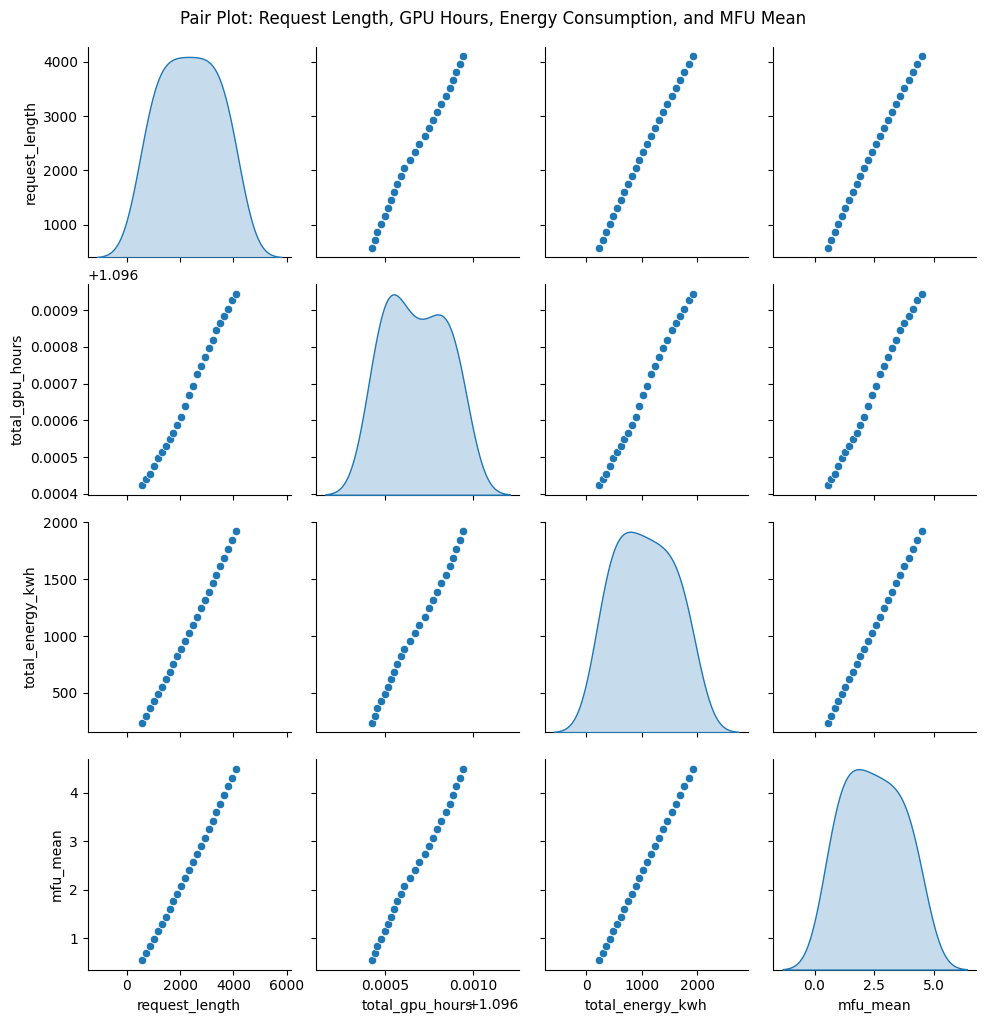

In [ ]:
# Select the columns we want to include in the pair plot
pairplot_columns = ['request_length', 'total_gpu_hours', 'total_energy_kwh', 'mfu_mean']

# Create a pair plot using seaborn
pairplot = sns.pairplot(df5[pairplot_columns], diag_kind='kde', markers='o', height=2.5)

# Update the title for the overall figure
pairplot.fig.suptitle('Pair Plot: Request Length, GPU Hours, Energy Consumption, and MFU Mean', y=1.02)

# Show the plot
plt.show()

#### Brief Interpretation of Results
- As the number of prefill tokens increases, MFU mean steadily rises, indicating that larger prefill tokens significantly increase the model's memory utilization.

- The heatmap suggests that longer request lengths lead to a considerable increase in energy consumption, particularly when MFU mean exceeds 3%. This indicates that higher memory utilization (MFU) results in greater energy demands, especially for long requests.

- The pair plot highlights linear relationships between variables like request length, total energy (kWh), and MFU mean. As request length increases, total energy and MFU also increase, demonstrating that more significant computational tasks drive up both energy usage and memory utilization.